# Compute some new Edges


The following edge Computations will be performed

1. Disease sublcass Punning: Anything connected to a Disease will also have the same edge added to Diseases that are a subclass of that Disease (single level).

2. Anatomy Subclass Punning
3.  Disease to GO-Term edges via Fisher's Exact


In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from itertools import chain
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from data_tools.plotting import count_plot_h
from data_tools import combine_nodes_and_edges
from data_tools.wiki import xref_to_wd_item, get_curi_xrefs
from data_tools.df_processing import combine_group_cols_on_char, split_col

In [2]:
prev_dir = Path('../2_pipeline/01c_WikiData_Cleanup/out/').resolve()
nodes = pd.read_csv(prev_dir.joinpath('nodes.csv'), dtype=str)
edges = pd.read_csv(prev_dir.joinpath('edges.csv'), dtype=str)

In [3]:
combo = combine_nodes_and_edges(nodes, edges)

In [4]:
new_edges = []

In [5]:
def pun_col(edge_to_pun, pun_map, pun_start=True):
    
    # Grab the correct columns
    if pun_start:
        pun_col = 'start_id'
        other_col = 'end_id'
    else:
        pun_col = 'end_id'
        other_col = 'start_id'

    # Ensure Punning Map does not include self
    drop_idx = pun_map[pun_map['start_id'] == pun_map['end_id']].index
    pun_map = pun_map.drop(drop_idx)
    
    pun_res = edge_to_pun.merge(pun_map, how='left', left_on=[pun_col], right_on=['end_id'], suffixes=('_orig', '_pun'))
        
    # if punning on end col, left and right are punned on end, so no suffix added... need to drop
    # this column
    if not pun_start:
        pun_res = pun_res.drop('end_id', axis=1)
    
    pun_res = pun_res.rename(columns={'start_id_pun': pun_col, other_col+'_orig': other_col})
    pun_res['dsrc_type'] = 'computed'
    pun_res['comp_type'] = 'punning'
    
    # Remove nan values, where there was no punning
    pun_res = pun_res.dropna(subset=[pun_col])
    
    return pun_res[['start_id', 'end_id', 'type', 'dsrc_type', 'comp_type']]

## Pun the diseases

In [6]:
start_dis = combo.query('start_label == "Disease" and type != "subclass_of"')
end_dis = combo.query('end_label == "Disease" and type != "subclass_of"')

disease_to_sub = combo.query('start_label == "Disease" and end_label == "Disease" and type == "subclass_of"')[['start_id', 'end_id']]

In [7]:
new_edges.append(pun_col(start_dis, disease_to_sub))
new_edges.append(pun_col(end_dis, disease_to_sub, False))

#### Recombine, so anatomy and disease terms are properly punned

In [8]:
edges = pd.concat([edges]+new_edges, sort=False, ignore_index=True)
edges = edges.drop_duplicates(subset=['start_id', 'end_id', 'type'])
combo = combine_nodes_and_edges(nodes, edges)
new_edges = []

## Anatomy Terms

In [9]:
start_ana = combo.query('start_label == "Anatomy" and type != "subclass_of"')
end_ana = combo.query('end_label == "Anatomy" and type != "subclass_of"')

anatomy_to_sub = combo.query('start_label == "Anatomy" and end_label == "Anatomy" and type == "subclass_of"')[['start_id', 'end_id']]

In [10]:
new_edges.append(pun_col(start_ana, anatomy_to_sub))
new_edges.append(pun_col(end_ana, anatomy_to_sub, False))

In [11]:
edges = pd.concat([edges]+new_edges, sort=False, ignore_index=True)
edges = edges.drop_duplicates(subset=['start_id', 'end_id', 'type'])
combo = combine_nodes_and_edges(nodes, edges)

## Examine Results

In [12]:
combo.query('start_label == "Disease" and comp_type == "punning"')

,start_id,end_id,type,dsrc_type,comp_type,start_name,end_name,start_label,end_label
1307588,Q1623006,Q2610154,presents,computed,punning,keratoconjunctivitis,red eye,Disease,Phenotype
1307589,Q18554026,Q2610154,presents,computed,punning,acute conjunctivitis,red eye,Disease,Phenotype
1307590,Q18967520,Q2610154,presents,computed,punning,pseudomembranous diphtheritic conjunctivitis,red eye,Disease,Phenotype
1307591,Q18555092,Q2610154,presents,computed,punning,chronic conjunctivitis,red eye,Disease,Phenotype
1307592,Q18555086,Q2610154,presents,computed,punning,papillary conjunctivitis,red eye,Disease,Phenotype
...,...,...,...,...,...,...,...,...,...
1314324,Q18557844,HP:0100575,presents,computed,punning,gallbladder lymphoma,gallbladder cancer,Disease,Phenotype
1314325,Q18557857,HP:0100575,presents,computed,punning,gallbladder melanoma,gallbladder cancer,Disease,Phenotype
1314326,Q18556909,HP:0100575,presents,computed,punning,adenosquamous gallbladder carcinoma,gallbladder cancer,Disease,Phenotype
1314327,Q19000824,HP:0100575,presents,computed,punning,recurrent cancer of gallbladder,gallbladder cancer,Disease,Phenotype


In [13]:
combo.query('end_label == "Disease" and comp_type == "punning"')

,start_id,end_id,type,dsrc_type,comp_type,start_name,end_name,start_label,end_label
551,Q26299555,Q936236,causes,computed,punning,Vibrio neonatus,Vibrio infectious disease,Taxon,Disease
552,Q26299337,Q936236,causes,computed,punning,Vibrio hangzhouensis,Vibrio infectious disease,Taxon,Disease
553,Q26299525,Q936236,causes,computed,punning,Vibrio mexicanus,Vibrio infectious disease,Taxon,Disease
554,Q26299459,Q936236,causes,computed,punning,Vibrio madracius,Vibrio infectious disease,Taxon,Disease
555,Q26299470,Q936236,causes,computed,punning,Vibrio mangrovi,Vibrio infectious disease,Taxon,Disease
...,...,...,...,...,...,...,...,...,...
1451495,Q208453,Q18557033,site_of,computed,punning,smooth muscle tissue,septal myocardial infarction,Anatomy,Disease
1451496,Q191817,Q18966134,site_of,computed,punning,striated muscle tissue,rippling muscle disease,Anatomy,Disease
1451497,Q208453,Q18966134,site_of,computed,punning,smooth muscle tissue,rippling muscle disease,Anatomy,Disease
1451498,Q191817,Q54086327,site_of,computed,punning,striated muscle tissue,rippling muscle disease 1,Anatomy,Disease


In [14]:
combo.query('end_label == "Disease" and comp_type == "punning" and type == "treats"')

,start_id,end_id,type,dsrc_type,comp_type,start_name,end_name,start_label,end_label
1367283,Q2938837,Q267759,treats,computed,punning,cariprazine,disorganized schizophrenia,Compound,Disease
1367284,Q2938837,Q2606101,treats,computed,punning,cariprazine,paranoid schizophrenia,Compound,Disease
1367285,Q2938837,Q1432717,treats,computed,punning,cariprazine,catatonic schizophrenia,Compound,Disease
1367286,Q2938837,Q2855814,treats,computed,punning,cariprazine,simple-type schizophrenia,Compound,Disease
1367287,Q2938837,Q3208822,treats,computed,punning,cariprazine,undifferentiated schizophrenia,Compound,Disease
...,...,...,...,...,...,...,...,...,...
1402322,Q4830631,Q18556928,treats,computed,punning,axitinib,pleomorphic carcinoma,Compound,Disease
1402323,Q4830631,Q19000704,treats,computed,punning,axitinib,Epstein-Barr virus related carcinoma,Compound,Disease
1402324,Q4830631,Q40301,treats,computed,punning,axitinib,parathyroid carcinoma,Compound,Disease
1402325,Q4830631,Q56014161,treats,computed,punning,axitinib,rare carcinoma of small intestine,Compound,Disease


In [15]:
combo.query('start_label == "Anatomy" and comp_type == "punning"')

,start_id,end_id,type,dsrc_type,comp_type,start_name,end_name,start_label,end_label
1402327,Q16364,Q18553856,site_of,computed,punning,throat,seminal vesicle chronic gonorrhea,Anatomy,Disease
1402328,Q16364,Q18551037,site_of,computed,punning,throat,seminal vesicle acute gonorrhea,Anatomy,Disease
1402329,Q9103,Q18557095,site_of,computed,punning,breast,breast fibrosarcoma,Anatomy,Disease
1402330,Q9103,Q18556953,site_of,computed,punning,breast,breast liposarcoma,Anatomy,Disease
1402331,Q9103,Q18556178,site_of,computed,punning,breast,breast rhabdomyosarcoma,Anatomy,Disease
...,...,...,...,...,...,...,...,...,...
1451495,Q208453,Q18557033,site_of,computed,punning,smooth muscle tissue,septal myocardial infarction,Anatomy,Disease
1451496,Q191817,Q18966134,site_of,computed,punning,striated muscle tissue,rippling muscle disease,Anatomy,Disease
1451497,Q208453,Q18966134,site_of,computed,punning,smooth muscle tissue,rippling muscle disease,Anatomy,Disease
1451498,Q191817,Q54086327,site_of,computed,punning,striated muscle tissue,rippling muscle disease 1,Anatomy,Disease


# Developing new Edges with stats tests

We can use a bridging concept (like genes) to bridge two other concepts, (like biological processes and diseases). Using a statistical test like Fisher's Exact, we can determine which Biological Processes have an association with which diseases.  

First let's look at what are linked to Genes or Proteins.

In [16]:
new_edges = []

In [17]:
combo.query('start_label == "Gene" or start_label == "Protein"')['end_label'].value_counts()

Taxon                 335554
Biological Process    280835
Molecular Function    222690
Cellular Component    203089
Protein               161889
Disease                29777
Phenotype                 55
Name: end_label, dtype: int64

In [18]:
combo.query('end_label == "Gene" or end_label == "Protein"')['start_label'].value_counts()

Gene        161889
Pathway      21864
Compound      3823
Name: start_label, dtype: int64

Can compute Disease to GO term, or Pathway

In [19]:
def get_item_to_gene_through_protein(item_label):
    pro_to_item = combo.query('start_label == "Protein" and end_label == @item_label')
    gene_to_pro = combo.query('start_label == "Gene" and end_label == "Protein" and type == "encodes"')

    item_to_gene = pro_to_item.merge(gene_to_pro, how='inner', left_on='start_id', right_on='end_id', suffixes=('_item', '_gene'))
    item_to_gene = item_to_gene.groupby('end_id_item')['start_id_gene'].apply(set).to_dict()
    return item_to_gene

In [20]:
# Not interested in non-human genes, so need to have them for filtering
tax_genes = set(combo.query('start_label == "Gene" and end_label == "Taxon"')['start_id'])

In [21]:
def filter_tax(mapper, keys=False):
    if keys:
        return {k: v for k, v in mapper.items() if k not in tax_genes}
    else:
        out = {k: {v for v in val if v not in tax_genes} for k, val in mapper.items()}
        out = {k: v for k, v in out.items() if len(v) > 0}
        return out

In [22]:
gene_to_dis = combo.query('start_label == "Gene" and end_label == "Disease"')
gene_to_dis = gene_to_dis.groupby('start_id')['end_id'].apply(set).to_dict()
gene_to_dis = filter_tax(gene_to_dis, keys=True)

dis_to_gene = combo.query('start_label == "Gene" and end_label == "Disease"')
dis_to_gene = dis_to_gene.groupby('end_id')['start_id'].apply(set).to_dict()
dis_to_gene = filter_tax(dis_to_gene)

In [23]:
dis_genes = set(chain(*dis_to_gene.values()))
    
def filter_to_disese_genes(mapper):
    out = {k: v&dis_genes for k, v in mapper.items()}
    out = {k: v for k, v in out.items() if len(v) > 0}
    return out

## BP associated_with Disease

In [24]:
bp_to_gene = get_item_to_gene_through_protein('Biological Process')
bp_to_gene = filter_tax(bp_to_gene)
bp_to_gene = filter_to_disese_genes(bp_to_gene)

In [25]:
def contingency_a_to_b_through_x(a_id, b_id, a_to_x_map, b_to_x_map, total):
    a_x = a_to_x_map[a_id]
    num_a_x = len(a_x)
    
    b_x = b_to_x_map[b_id]
    num_b_x = len(b_x)

    num_ab_x = len(a_x & b_x)
    
    num_not_a_or_b = total - len(a_x | b_x)
    
    return num_ab_x, num_a_x-num_ab_x, num_b_x-num_ab_x, num_not_a_or_b

In [26]:
from collections import defaultdict

In [27]:
def invert_one_to_many_map(mapper):
    inverted = defaultdict(set)
    for k, v_set in gene_to_dis.items():
        for v in v_set:
            inverted[v].add(k)
    return dict(inverted)

In [28]:
def run_all_compaisons(a_name, b_name, x_name, a_to_x_map, b_to_x_map, name_map, x_to_b_map=None):

    # Get the total number of X common to both conditions
    total = len(set(chain(*a_to_x_map.values())).intersection(set(chain(*b_to_x_map.values()))))

    # Need X to B to quickly determine what tests to do
    if x_to_b_map is None:
        x_to_b_map = invert_one_to_many_map(b_to_x_map)
    
    # Initalize output...
    out_data = {a_name: [],
                a_name+'_name': [],
                b_name: [],
                b_name+'_name': [],
                a_name+'_'+b_name+'_'+x_name+'s': [],
                'only_'+a_name+'_'+x_name+'s': [],
                'only_'+b_name+'_'+x_name+'s': [],
                'other_'+x_name+'s': [],
                'odd_r': [],
                'p_val': []}


    for a_id in tqdm(set(a_to_x_map.keys())):

        # Only test the subset of B vals that contain Xs common to A
        # Speeds things up, so really try to do this
        to_test = set.union(*[x_to_b_map.get(x, set()) for x in a_to_x_map[a_id]])

        if not to_test:
            continue
        
        a_item_name = name_map[a_id]

        for b_id in to_test:

            b_item_name = name_map[b_id]

            num_ab, num_a, num_b, num_remain = contingency_a_to_b_through_x(a_id, b_id, a_to_x_map, b_to_x_map, total)
            odd_r, p_val = fisher_exact([[num_ab, num_a],[num_b, num_remain]])

            out_data[a_name].append(a_id)
            out_data[a_name+'_name'].append(a_item_name)
            out_data[b_name].append(b_id)
            out_data[b_name+'_name'].append(b_item_name)
            out_data[a_name+'_'+b_name+'_'+x_name+'s'].append(num_ab)
            out_data['only_'+a_name+'_'+x_name+'s'].append(num_a)
            out_data['only_'+b_name+'_'+x_name+'s'].append(num_b)
            out_data['other_'+x_name+'s'].append(num_remain)
            out_data['odd_r'].append(odd_r)
            out_data['p_val'].append(p_val)


    return pd.DataFrame(out_data)


In [29]:
bp_to_dis_data = run_all_compaisons('bp', 'disease', 'gene', bp_to_gene, dis_to_gene, 
                                     dict(zip(nodes['id'], nodes['name'])), gene_to_dis)

100%|██████████| 9571/9571 [10:41<00:00, 14.93it/s]


In [30]:
def add_disease_wise_bonferroni_pval_correction(data, ini_alpha):
    
    out = data.copy()
    corr_factor = out['disease'].value_counts().to_dict()
    corr_factor_s = out['disease'].map(corr_factor)
    sig_thresh = ini_alpha / corr_factor_s
    out['adj_p'] = out['p_val'] * (ini_alpha / sig_thresh)
    out['is_sig'] = out['adj_p'] < ini_alpha
    
    return out

In [31]:
def add_disease_wise_benjamini_hochberg_pval_correction(data, ini_alpha):
    
    out = data.copy()
    
    # defineid as i
    rank = out.groupby('disease')['p_val'].rank().astype(int)

    # defineid as m
    total = out.groupby('disease').apply(len).to_dict()
    total = out['disease'].map(total)

    # The comparison value is (i/m)*Q where Q = desired FDR
    out['bh_val'] = (rank / total) * ini_alpha
    
    # Now the threshold is the highest p-val where p-val < (i/m)*Q
    is_less_than_iqm = out['p_val'] < out['bh_val']
    # Find the Highest pval
    thresh_map = out[is_less_than_iqm].groupby('disease')['p_val'].max().to_dict()
    out['thresh'] = out['disease'].map(thresh_map)
    
    # Do the significance test
    out['is_sig'] = out['p_val'] <= out['thresh'] 

    return out

In [32]:
def add_benjamini_hochberg_pval_correction(data, ini_alpha):
    
    out = data.copy()

    # defineid as i
    rank = out['p_val'].rank(method='first').astype(int)
    
    # defineid as m
    total = len(out)

    # The comparison value is (i/m)*Q where Q = desired FDR
    out['bh_val'] = (rank / total) * ini_alpha
    
    # Now the threshold is the highest p-val where p-val < (i/m)*Q
    is_greater = out['bh_val'] > out['p_val']
    # Find the Highest pval
    out['thresh'] = out[is_greater]['p_val'].max()

    # Do the significance test
    out['is_sig'] = out['p_val'] <= out['thresh']

    return out

In [33]:
# Going with an alpha values of 0.25 because we'd like higher recall
# for these associations
bp_to_dis_data = add_disease_wise_bonferroni_pval_correction(bp_to_dis_data, 0.25)

In [34]:
print("{:,} Comparisons".format(len(bp_to_dis_data)))
print("{:,} Number Significant".format(bp_to_dis_data['is_sig'].sum()))
print("{:1.3} Fraction Significant".format(bp_to_dis_data['is_sig'].sum() / len(bp_to_dis_data)))

419,610 Comparisons
69,365 Number Significant
0.165 Fraction Significant


## Do some plotting 

In [35]:
def get_plot_data(result):
    plot_data = pd.DataFrame()
    plot_data['num_sig'] = result.groupby('disease')['is_sig'].sum()

    plot_data['total_obs'] = result.groupby('disease').apply(len)
    plot_data['frac_sig'] = plot_data['num_sig'] / plot_data['total_obs']
    return plot_data

In [36]:
def plot_results(plot_data):

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(16)
    fig.set_figheight(6)

    sns.violinplot(y='total_obs', data=plot_data, cut=0, ax=ax[0])
    ax[0].set_title('Number of Comparisons')
    ax[0].set_ylabel('count')
    sns.violinplot(y='num_sig', data=plot_data, cut=0, ax=ax[1])
    ax[1].set_title('Number Significant')
    ax[1].set_ylabel('count')
    sns.violinplot(y='frac_sig', data=plot_data, cut=0, ax=ax[2])
    ax[2].set_title('Fraction Significant')
    ax[2].set_ylabel('fraction')

    for a in ax:
        a.tick_params(axis='x', which='both', bottom=False)

    fig.suptitle('Values Per Disease', fontsize=16);

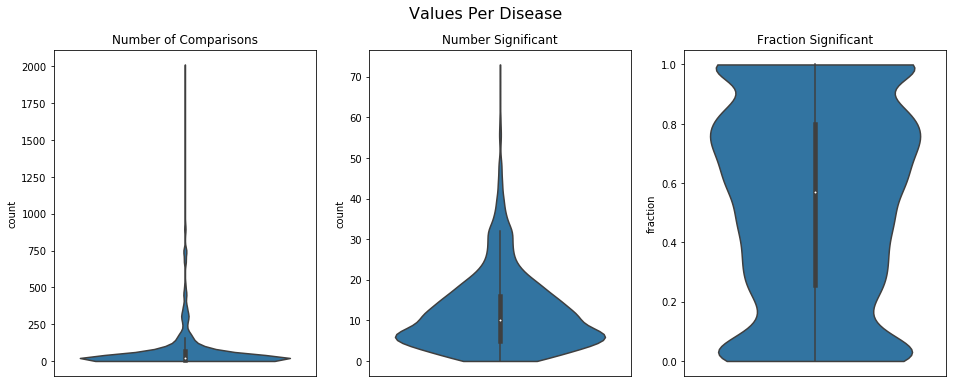

In [37]:
plot_results(get_plot_data(bp_to_dis_data))

## Create Edges

In [38]:
def comparisons_to_edges(comp_data, start_col, end_col):

    # Only take the signficant results
    out_data = comp_data.query('is_sig').copy()

    # Rename the approprate identifier columns
    out_data = out_data.rename(columns={start_col: 'start_id', end_col: 'end_id'})
    
    # give the correct types
    out_data['type'] = 'associated_with'
    out_data['dsrc_type'] = 'computed'
    out_data['comp_type'] = 'fishers_exact'
    
    # Return the data
    return out_data[['start_id', 'end_id', 'type', 'dsrc_type', 'comp_type', 'p_val', 'adj_p']]

In [39]:
this_edge = comparisons_to_edges(bp_to_dis_data, 'bp', 'disease')
this_edge.head()

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p
0,Q21096252,Q27677809,associated_with,computed,fishers_exact,0.000229,0.002064
1,Q14885822,Q18556214,associated_with,computed,fishers_exact,0.000688,0.023394
2,Q14885822,Q18556213,associated_with,computed,fishers_exact,0.000688,0.023394
3,Q14885822,Q18553474,associated_with,computed,fishers_exact,0.000688,0.050917
4,Q14885822,Q32145508,associated_with,computed,fishers_exact,0.000688,0.050917


In [40]:
new_edges.append(this_edge)

## MF associated_with Disease

In [41]:
mf_to_gene = get_item_to_gene_through_protein('Molecular Function')
mf_to_gene = filter_tax(mf_to_gene)
mf_to_gene = filter_to_disese_genes(mf_to_gene)

mf_to_dis_data = run_all_compaisons('mf', 'disease', 'gene', mf_to_gene, dis_to_gene, 
                                     dict(zip(nodes['id'], nodes['name'])), gene_to_dis)

100%|██████████| 2937/2937 [03:39<00:00, 13.39it/s]


136,475 Comparisons
26,743 Number Significant
0.196 Fraction Significant


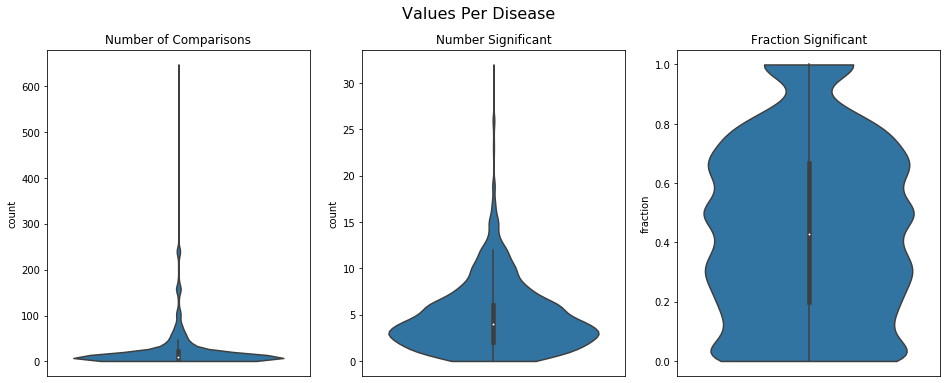

In [42]:
mf_to_dis_data = add_disease_wise_bonferroni_pval_correction(mf_to_dis_data, 0.25)

print("{:,} Comparisons".format(len(mf_to_dis_data)))
print("{:,} Number Significant".format(mf_to_dis_data['is_sig'].sum()))
print("{:1.3} Fraction Significant".format(mf_to_dis_data['is_sig'].sum() / len(mf_to_dis_data)))

plot_results(get_plot_data(mf_to_dis_data))

In [43]:
this_edge = comparisons_to_edges(mf_to_dis_data, 'mf', 'disease')
this_edge.head()

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p
0,Q14864468,Q32143975,associated_with,computed,fishers_exact,4.682744e-04,0.002810
1,Q14864468,Q32146085,associated_with,computed,fishers_exact,4.682744e-04,0.001405
2,Q14864468,Q18553397,associated_with,computed,fishers_exact,4.682744e-04,0.001405
3,Q14864468,Q16570127,associated_with,computed,fishers_exact,3.289984e-07,0.000003
4,Q14864468,Q7316761,associated_with,computed,fishers_exact,4.682744e-04,0.002810


In [44]:
new_edges.append(this_edge)

## CC associated_with Disease

In [45]:
cc_to_gene = get_item_to_gene_through_protein('Cellular Component')
cc_to_gene = filter_tax(cc_to_gene)
cc_to_gene = filter_to_disese_genes(cc_to_gene)

cc_to_dis_data = run_all_compaisons('cc', 'disease', 'gene', cc_to_gene, dis_to_gene, 
                                     dict(zip(nodes['id'], nodes['name'])), gene_to_dis)

100%|██████████| 1336/1336 [03:34<00:00,  6.23it/s]


123,019 Comparisons
17,696 Number Significant
0.144 Fraction Significant


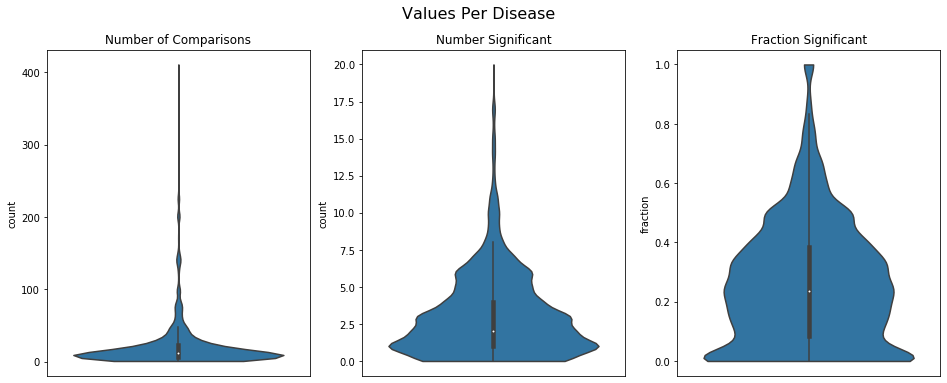

In [46]:
cc_to_dis_data = add_disease_wise_bonferroni_pval_correction(cc_to_dis_data, 0.25)

print("{:,} Comparisons".format(len(cc_to_dis_data)))
print("{:,} Number Significant".format(cc_to_dis_data['is_sig'].sum()))
print("{:1.3} Fraction Significant".format(cc_to_dis_data['is_sig'].sum() / len(cc_to_dis_data)))

plot_results(get_plot_data(cc_to_dis_data))

In [47]:
this_edge = comparisons_to_edges(cc_to_dis_data, 'cc', 'disease')
this_edge.head()

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p
3,Q14860434,Q431643,associated_with,computed,fishers_exact,0.004767,0.247900
4,Q14860434,Q18554808,associated_with,computed,fishers_exact,0.004767,0.247900
10,Q14860434,Q22938881,associated_with,computed,fishers_exact,0.000682,0.009548
11,Q14860434,Q60195167,associated_with,computed,fishers_exact,0.004767,0.247900
14,Q14860434,Q22938883,associated_with,computed,fishers_exact,0.000682,0.009548


In [48]:
new_edges.append(this_edge)

## Pathway associated_with Disease

In [49]:
pw_to_gene = (combo.query('start_label == "Pathway" and end_label == "Gene"')
                   .groupby('start_id')['end_id']
                   .apply(set)
                   .to_dict())
pw_to_gene = filter_tax(pw_to_gene)
pw_to_gene = filter_to_disese_genes(pw_to_gene)

pw_to_dis_data = run_all_compaisons('pw', 'disease', 'gene', pw_to_gene, dis_to_gene, 
                                     dict(zip(nodes['id'], nodes['name'])), gene_to_dis)

100%|██████████| 535/535 [01:53<00:00,  4.70it/s]


71,181 Comparisons
11,277 Number Significant
0.158 Fraction Significant


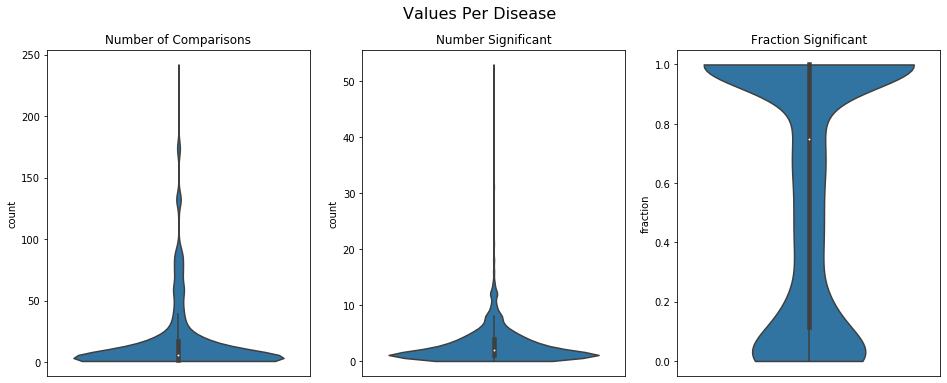

In [50]:
pw_to_dis_data = add_disease_wise_bonferroni_pval_correction(pw_to_dis_data, 0.25)

print("{:,} Comparisons".format(len(pw_to_dis_data)))
print("{:,} Number Significant".format(pw_to_dis_data['is_sig'].sum()))
print("{:1.3} Fraction Significant".format(pw_to_dis_data['is_sig'].sum() / len(pw_to_dis_data)))

plot_results(get_plot_data(pw_to_dis_data))

In [51]:
this_edge = comparisons_to_edges(pw_to_dis_data, 'pw', 'disease')
this_edge.head()

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p
1,Q55446273,Q55782463,associated_with,computed,fishers_exact,0.008360,0.033442
10,Q55446273,Q383228,associated_with,computed,fishers_exact,0.016655,0.066619
12,Q55446273,Q3338664,associated_with,computed,fishers_exact,0.008360,0.033442
14,Q55446273,Q53661592,associated_with,computed,fishers_exact,0.008360,0.050163
16,Q55446273,Q55782081,associated_with,computed,fishers_exact,0.008360,0.058523


In [52]:
new_edges.append(this_edge)

## Add in the new edges

In [53]:
edges = pd.concat([edges]+new_edges, sort=False, ignore_index=True)
combo = combine_nodes_and_edges(nodes, edges)

new_edges = []

# Final Computation: Merge Gene/Protein

We will do the following:

1. Map all Proteins in edges to Genes
2. Drop edges with Mapped Proteins
3. Merge Xrefs on Merged Gene/Proteins

## 1. Mapping Proteins to Genes

In [54]:
# pun map cols are ['start_id': result_col, 'end_id': merge_map_col]
gene_to_prot = edges.query('type == "encodes"')[['start_id', 'end_id']]
gene_to_prot.head()

,start_id,end_id
351758,Q62183590,Q62183588
351759,Q62183598,Q62183595
351760,Q62183604,Q62183602
351761,Q62183608,Q62183606
351762,Q62183613,Q62183610


In [55]:
start_prot = combo.query('start_label == "Protein" and type != "encodes"')
end_prot = combo.query('end_label == "Protein" and type != "encodes"')

In [56]:
start_merge = pun_col(start_prot, gene_to_prot)
end_merge = pun_col(end_prot, gene_to_prot, False)

start_merge['comp_type'] = 'merge'
end_merge['comp_type'] = 'merge'

new_edges.append(start_merge)
new_edges.append(end_merge)

## 2. Removing edges with successful mappings

We're merging Proteins and Genes... Therefore we want to remove edges of Protein -> X or Y -> Protein.

However, some (primarly non-human) proteins may not be mappable via a protein to gene edge, so we
will keep those for now

In [57]:
found_prots = gene_to_prot['end_id'].tolist()
drop_idx = edges.query('start_id in @found_prots or end_id in @found_prots').index

print('{:,}'.format(len(edges)))
edges = edges.drop(drop_idx)
print('{:,}'.format(len(edges)))

1,576,223
604,418


In [58]:
len(pd.concat(new_edges)) + 476963

1293272

## 3. Merging the Xrefs in the nodes.

In [59]:
def combine_xrefs_and_set_label(combined_nodes, label):
    add_nodes = combine_group_cols_on_char(combined_nodes, ['id'], ['xrefs'], prog=False)
    add_nodes['label'] = label
    
    return add_nodes[['id', 'name', 'label', 'xrefs']]

In [60]:
mapped_prot_genes = gene_to_prot.stack().values

In [61]:
mrg = nodes.query('id in @mapped_prot_genes').merge(gene_to_prot, how='left', left_on ='id', right_on='end_id' )
mrg = mrg.rename(columns={'id':'old_id'})
mrg['start_id'] = mrg['start_id'].fillna(mrg['old_id'])
mrg = mrg.rename(columns={'start_id': 'id'})
mrg

,old_id,name,label,xrefs,id,end_id
0,Q62183588,TcCLB.509395.10:mRNA,Protein,UniProt:Q4DJR6,Q62183590,Q62183588
1,Q62183595,TcCLB.509395.20:mRNA,Protein,UniProt:Q4DJR5,Q62183598,Q62183595
2,Q62183602,TcCLB.509395.30:mRNA,Protein,UniProt:Q4DJR4,Q62183604,Q62183602
3,Q62183606,TcCLB.509395.40:mRNA,Protein,UniProt:Q4DJR3,Q62183608,Q62183606
4,Q62183610,TcCLB.509395.50:mRNA,Protein,UniProt:Q4DJR2,Q62183613,Q62183610
...,...,...,...,...,...,...
317235,Q170617,glucagon,Protein,CHEBI:5391|UniProt:P01275|PCID:16186314|DB:000...,Q14821391,Q170617
317236,Q2993328,beta-endorphin,Protein,UniProt:P01189|PCID:16132316|UNII:3S51P4W3XQ|C...,Q14819793,Q2993328
317237,Q4063639,alpha-melanocyte-stimulating hormone,Protein,CHEMBL:CHEMBL214332|UniProt:P01189|UNII:OVF025...,Q14819793,Q4063639
317238,Q412999,angiotensin II,Protein,KEGG:C02135|UniProt:P01019|PCID:172198|MESH:D0...,Q14859647,Q412999


In [62]:
gene_id_to_xref = combine_xrefs_and_set_label(mrg, 'Gene').set_index('id')['xrefs'].to_dict()

nodes['xrefs'] = nodes['id'].map(gene_id_to_xref).fillna(nodes['xrefs'])

Some edges may have gone to both gene and protein. Since we have now mapped proteins to genes, they will be duplicated.

We will now drop any potential duplicates

In [63]:
edges = pd.concat([edges]+new_edges, sort=False, ignore_index=True)

print('{:,}'.format(len(edges)))
edges = edges.drop_duplicates(subset=['start_id', 'end_id', 'type'], keep='first')
print('{:,}'.format(len(edges)))

1,420,727
1,261,125


# Remove mapper edges

Now that punning is complete, `subclass_of` and `encodes` edges should be removed

In [64]:
drop_idx = edges.query('type == "encodes" or type == "subclass_of"').index

print('{:,}'.format(len(edges)))
edges = edges.drop(drop_idx)
print('{:,}'.format(len(edges)))

1,261,125
1,223,823


# Check and save...

In [65]:
combo = combine_nodes_and_edges(nodes, edges)

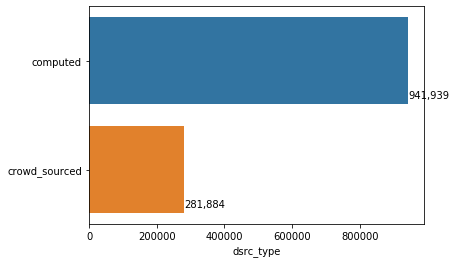

In [66]:
count_plot_h(edges['dsrc_type'])

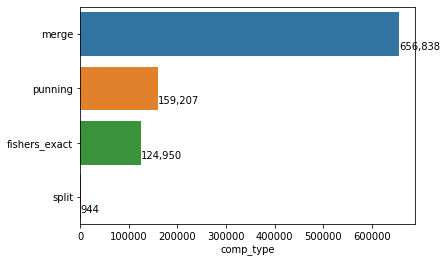

In [67]:
count_plot_h(edges['comp_type'])

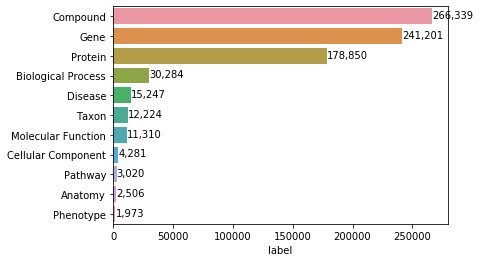

In [68]:
count_plot_h(nodes['label'])

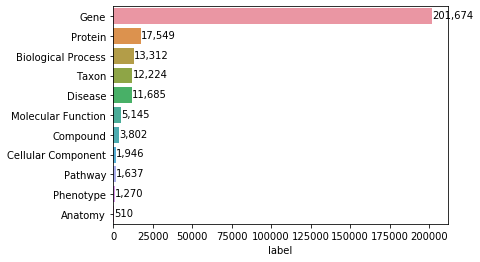

In [69]:
e_ids = edges[['start_id', 'end_id']].stack().values
nodes_filt = nodes.query('id in @e_ids')

count_plot_h(nodes_filt['label'])

In [70]:
meta_edges = combo['start_label'] + '_' + combo['type'] + '_' + combo['end_label']
meta_edges.nunique()

35

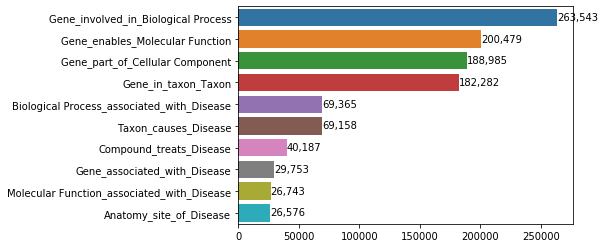

In [71]:
count_plot_h(meta_edges.value_counts().head(10))

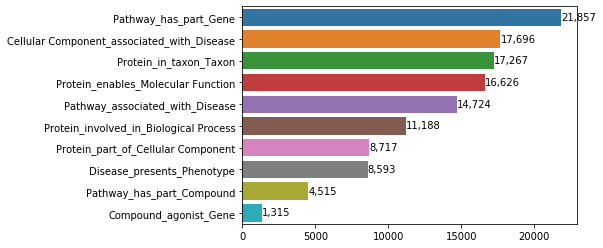

In [72]:
count_plot_h(meta_edges.value_counts().head(20).tail(10))

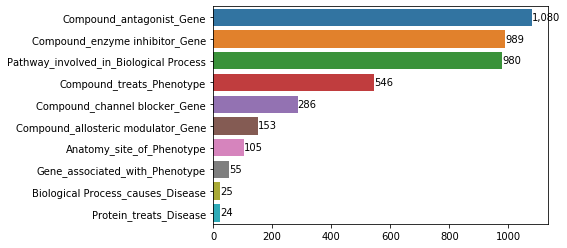

In [73]:
count_plot_h(meta_edges.value_counts().head(30).tail(10))

## Save the data

In [74]:
edges['source'] = 'WikiData'
edges['license'] = 'CC0 1.0'

In [75]:
this_file = '01d_WikiData_Compute'
out_dir = Path('../2_pipeline/').joinpath(this_file, 'out').resolve()

out_dir.mkdir(parents=True, exist_ok=True)

nodes.to_csv(out_dir.joinpath('nodes.csv'), index=False)
nodes_filt.to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)
edges.to_csv(out_dir.joinpath('edges.csv'), index=False)